In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
import catboost
from scipy.special import logsumexp, expit

from src.nf import (
    FCNN,
    ConditionalNormalizingFlowModel,
    UnconditionalNormalizingFlowModel,
    cond_neg_log_likelihood,
    one_hot_encoding,
    ConditionalMAF,
    TorchDistributionWrapper,
    ConditionalNormal,
    TorchDistributionWrapper,
    NormalizingFlowModel,
#     MAF,
    BaseConditionalFlow,
    wrap_cb,
    ConditionalCalibratedModel,
    deduce_calibration_constant,
    FakeCondDistribution,
    BaseConditionalDistribution,
    BaseUnconditionalDistribution,
    CalibratedModel,
    neg_log_likelihood,
    NFLibFlowAdapter,
    ActNorm
)
from src.nf.classic.utils import Densnet
from src.mrartemev_nflib.flows import MAF, InvertiblePermutation
from src.mrartemev_nflib.nn import ARMLP
from src.mrartemev_nflib.nn.networks_utils import MaskedLinear

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
! nvidia-smi

Wed May 27 19:10:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 34%   69C    P2    82W / 250W |   8853MiB / 11178MiB |     12%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   28C    P8     8W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [6]:
# ! wget https://zenodo.org/record/1161203/files/data.tar.gz?download=1

In [7]:
# ! mkdir data
# ! mv 'data.tar.gz?download=1' data/data.tar.gz
# ! ls data

In [8]:
# ! tar -zxvf data/data.tar.gz
# ! ls data

In [9]:
# ! ls data/mnist

In [10]:
import gzip
import _pickle as pickle

def disp_imdata(xs, imsize, layout=(1,1)):
    """
    Displays an array of images, a page at a time. The user can navigate pages with
    left and right arrows, start over by pressing space, or close the figure by esc.
    :param xs: an numpy array with images as rows
    :param imsize: size of the images
    :param layout: layout of images in a page
    :return: none
    """

    num_plots = np.prod(layout)
    num_xs = xs.shape[0]
    idx = [0]

    # create a figure with suplots
    fig, axs = plt.subplots(layout[0], layout[1])

    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    for ax in axs:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    def plot_page():
        """Plots the next page."""

        ii = np.arange(idx[0], idx[0]+num_plots) % num_xs

        for ax, i in zip(axs, ii):
            ax.imshow(xs[i].reshape(imsize), cmap='gray', interpolation='none')
            ax.set_title(str(i))

        fig.canvas.draw()

    def on_key_event(event):
        """Event handler after key press."""

        key = event.key

        if key == 'right':
            # show next page
            idx[0] = (idx[0] + num_plots) % num_xs
            plot_page()

        elif key == 'left':
            # show previous page
            idx[0] = (idx[0] - num_plots) % num_xs
            plot_page()

        elif key == ' ':
            # show first page
            idx[0] = 0
            plot_page()

        elif key == 'escape':
            # close figure
            plt.close(fig)

    fig.canvas.mpl_connect('key_press_event', on_key_event)
    plot_page()

def logit(x):
    """
    Elementwise logit (inverse logistic sigmoid).
    :param x: numpy array
    :return: numpy array
    """
    return np.log(x / (1.0 - x))


class MNIST:
    """
    The MNIST dataset of handwritten digits.
    """

    alpha = 1.0e-6

    class Data:
        """
        Constructs the dataset.
        """

        def __init__(self, data, logit, dequantize, rng):

            x = self._dequantize(data[0], rng) if dequantize else data[0]  # dequantize pixels
            self.x = self._logit_transform(x) if logit else x              # logit
            self.labels = data[1]                                          # numeric labels
            self.y = one_hot_encoding(self.labels, 10)                     # 1-hot encoded labels
            self.N = self.x.shape[0]                                       # number of datapoints

        @staticmethod
        def _dequantize(x, rng):
            """
            Adds noise to pixels to dequantize them.
            """
            return x + rng.rand(*x.shape) / 256.0

        @staticmethod
        def _logit_transform(x):
            """
            Transforms pixel values with logit to be unconstrained.
            """
            return logit(MNIST.alpha + (1 - 2*MNIST.alpha) * x)

    def __init__(self, logit=False, dequantize=True):

        # load dataset
        f = gzip.open('data/mnist/mnist.pkl.gz', 'rb')
#         f = open('data/mnist.pkl', 'rb')
        trn, val, tst = pickle.load(f, encoding='latin1') 
        f.close()

        rng = np.random.RandomState(42)
        self.trn = self.Data(trn, logit, dequantize, rng)
        self.val = self.Data(val, logit, dequantize, rng)
        self.tst = self.Data(tst, logit, dequantize, rng)

        self.n_dims = self.trn.x.shape[1]
        self.n_labels = self.trn.y.shape[1]
        self.image_size = [int(np.sqrt(self.n_dims))] * 2

    def show_pixel_histograms(self, split, pixel=None):
        """
        Shows the histogram of pixel values, or of a specific pixel if given.
        """

        data_split = getattr(self, split, None)
        if data_split is None:
            raise ValueError('Invalid data split')

        if pixel is None:
            data = data_split.x.flatten()

        else:
            row, col = pixel
            idx = row * self.image_size[0] + col
            data = data_split.x[:, idx]

        n_bins = int(np.sqrt(data_split.N))
        fig, ax = plt.subplots(1, 1)
        ax.hist(data, n_bins, normed=True)
        plt.show()

    def show_images(self, split):
        """
        Displays the images in a given split.
        :param split: string
        """

        # get split
        data_split = getattr(self, split, None)
        if data_split is None:
            raise ValueError('Invalid data split')

        # display images
        disp_imdata(data_split.x, self.image_size, [6, 10])

        plt.show()

In [11]:
# https://github.com/gpapamak/maf/blob/ea057bf6dd2e53dd8a0bc162880db72cf99e063d/experiments.py#L51
mnist = MNIST(logit=True, dequantize=True)

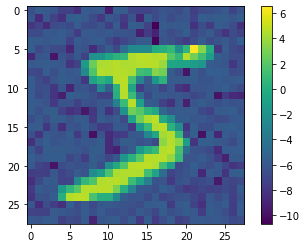

In [12]:
X, Y = mnist.trn.x, mnist.trn.y
dim, cond_dim = X.shape[1], Y.shape[1]
X = X.astype(np.float32)
X_train, X_test, Y_train, Y_test = mnist.trn.x.astype(np.float32), mnist.tst.x.astype(np.float32), mnist.trn.y.astype(np.float32), mnist.tst.y.astype(np.float32)

plt.imshow(mnist.trn.x[0].reshape(28, 28))
plt.colorbar()

In [13]:
X_train_tensor = torch.from_numpy(X_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)
Y_train_tensor = torch.from_numpy(Y_train).to(device)
Y_test_tensor = torch.from_numpy(Y_test).to(device)

In [14]:
def data_gen(X, Y, batch_size):
    while True:
        perm = torch.randperm(len(X))
        X, Y = X[perm], Y[perm]
        for i in range(0, len(X), batch_size):
            yield X[i: i + batch_size], Y[i: i + batch_size]

In [20]:
flows = []
for i in range(8):
    flows.append(ActNorm(dim).to(device))
    flows.append(NFLibFlowAdapter(MAF(dim, ARMLP, context=cond_dim, depth=4, hidden_features=768).to(device)))
#     flows.append(NFLibFlowAdapter(InvertiblePermutation(dim).to(device)))

prior = ConditionalNormal(
    torch.zeros(dim).to(device), torch.eye(dim).to(device),
    nn.Linear(cond_dim, dim), nn.Linear(cond_dim, dim)
).to(device)
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [21]:
! nvidia-smi

Wed May 27 19:12:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 39%   71C    P2    79W / 250W |   8663MiB / 11178MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   28C    P8     7W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

/home/robdrynkin/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


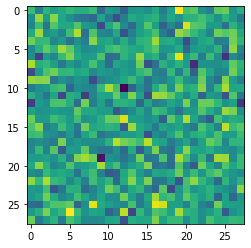

In [17]:
samples = model.sample_n(1, Y_train_tensor[:1]).detach().cpu().numpy()

plt.imshow(samples[0].reshape(28, 28))

In [22]:
epoches = 5001
metrics_ll_train, metrics_ll_test = [], []
best_loss = -10000

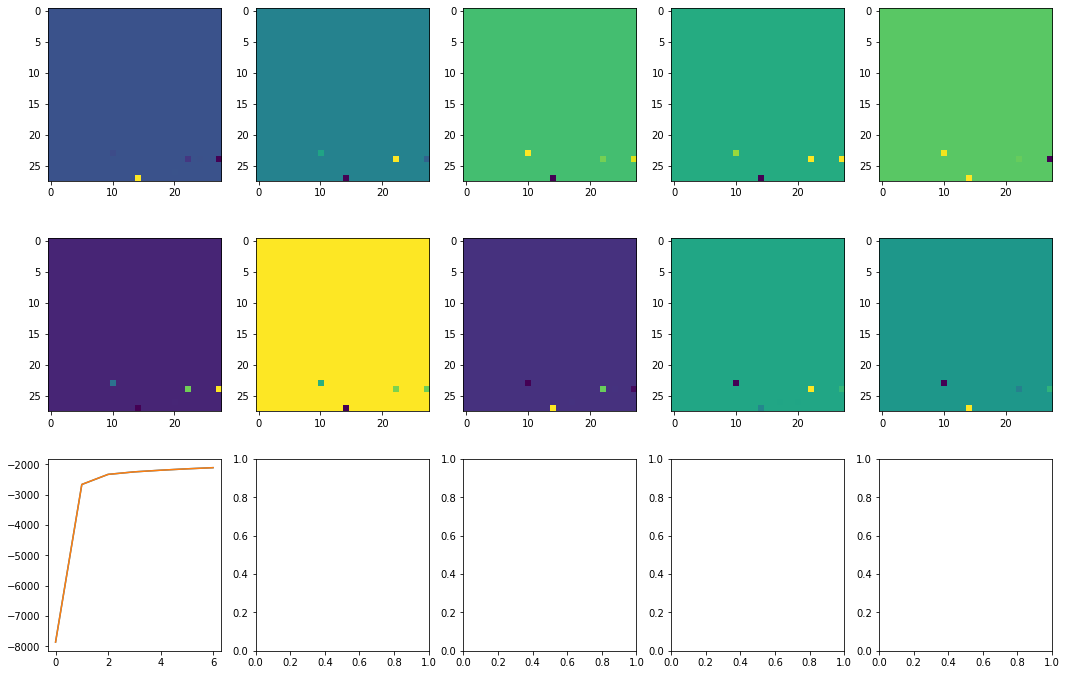

In [ ]:
train_gen = data_gen(X_train_tensor, Y_train_tensor, 10000)
test_gen = data_gen(X_test_tensor, Y_test_tensor, 10000)

for i in range(len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    logp_x = model.log_prob(*next(train_gen))
    loss = -torch.mean(logp_x)
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        model.eval()
        with torch.no_grad():
            log_prob = model.log_prob(X_train_tensor[:10000], Y_train_tensor[:10000])
            metrics_ll_train.append(torch.mean(log_prob).item())
            log_prob = model.log_prob(X_test_tensor[:10000], Y_test_tensor[:10000])
            metrics_ll_test.append(torch.mean(log_prob).item())
            
            n_samples = 10
            cond = torch.eye(10).to(device)
            samples = model.sample_n(10, cond).detach().cpu().numpy()
            
            if metrics_ll_test[-1] > best_loss:
                torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'metrics_ll_train': metrics_ll_train,
                    'metrics_ll_test': metrics_ll_test,
                }, './mnist_best_1')

        clear_output(False)
        fig, axs = plt.subplots(3, 5, figsize=(18, 12))
        
        for i in range(10):
            axs[i // 5, i % 5].imshow(samples[i].reshape(28, 28))
        
        axs[2, 0].plot(metrics_ll_train)
        axs[2, 0].plot(metrics_ll_test)
        plt.show()

In [17]:
checkpoint = torch.load('./mnist_best')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

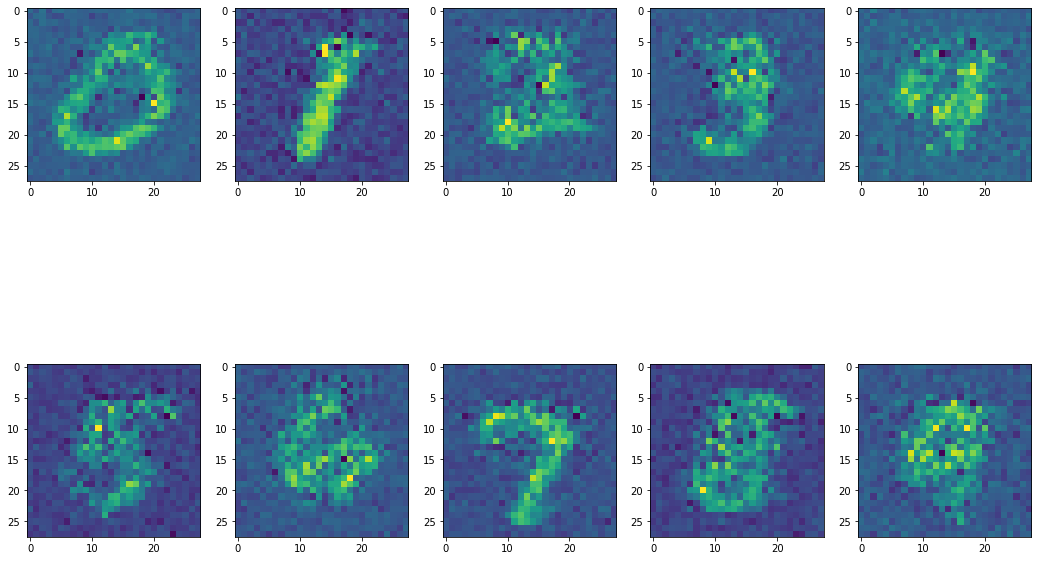

In [19]:
cond = torch.eye(10).to(device)
samples = model.sample_n(10, cond).detach().cpu().numpy()
clear_output(False)
fig, axs = plt.subplots(2, 5, figsize=(18, 12))

for i in range(10):
    axs[i // 5, i % 5].imshow(samples[i].reshape(28, 28))

In [20]:
model.eval()
with torch.no_grad():
    samples = model.sample_n(len(X_train), Y_train_tensor).detach().cpu().numpy()
samples.shape

(50000, 784)

In [93]:
X_clf = np.vstack([samples.reshape(-1, 1, 28, 28), X_train.reshape(-1, 1, 28, 28)])
Y_clf = np.hstack([np.zeros(len(samples)), np.ones(len(X_train))]).astype(np.float32)
perm = torch.randperm(len(X_clf))
X_clf, Y_clf = X_clf[perm], Y_clf[perm]

n = X_clf.shape[0]
X_clf_train, X_clf_test, Y_clf_train, Y_clf_test = X_clf[: n * 7 // 10], X_clf[n * 7 // 10: ], Y_clf[: n * 7 // 10], Y_clf[n * 7 // 10: ]

In [117]:
X_clf_train_tensor = torch.from_numpy(X_clf_train).to(device)
X_clf_test_tensor = torch.from_numpy(X_clf_test).to(device)
Y_clf_train_tensor = torch.from_numpy(Y_clf_train).to(device)
Y_clf_test_tensor = torch.from_numpy(Y_clf_test).to(device)

In [118]:
class MNISTClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(3, 5, 5)
        self.conv4 = nn.Conv2d(5, 5, 5)
        self.fc1 = nn.Linear(5 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
#         print(x.shape)
#         x = self.pool(F.relu(self.conv1(x)))
#         print(x.shape)
#         x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
#         print(x.shape)
        x = x.view(-1, 5 * 4 * 4)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1)

In [119]:
clf = MNISTClf().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(clf.parameters(), lr=0.005)

In [120]:
epoches = 5001
loss_train, loss_test = [], []

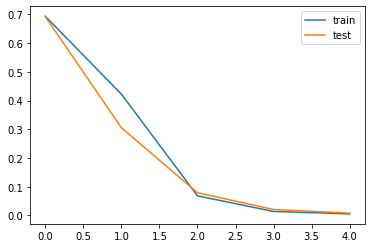

KeyboardInterrupt: 

In [121]:
train_gen = data_gen(X_clf_train_tensor, Y_clf_train_tensor, 5000)
test_gen = data_gen(X_clf_test_tensor, Y_clf_test_tensor, 5000)

for i, (X_batch, Y_batch) in zip(range(len(loss_train), epoches), train_gen):
    clf.train()
    optimizer.zero_grad()
    logits = clf(X_batch)
    loss = criterion(logits, Y_batch)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        loss_train.append(loss.item())
        clf.eval()
        with torch.no_grad():
            X_batch, Y_batch = next(test_gen)
            loss_test.append(criterion(clf(X_batch), Y_batch).item())
        
        clear_output(False)
        plt.plot(loss_train, label='train')
        plt.plot(loss_test, label='test')
        plt.legend()
        plt.show()

In [122]:
clf.eval()
with torch.no_grad():
    X_batch, Y_batch = next(test_gen)
    preds = clf(X_batch).detach().cpu().numpy()
    print(roc_auc_score(Y_batch.detach().cpu().numpy(), preds))

0.9999923198513123


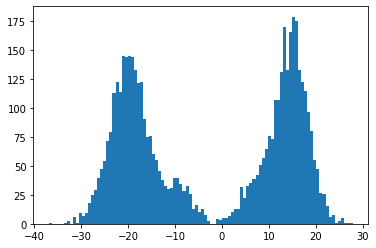

In [123]:
plt.hist(preds, bins=100);

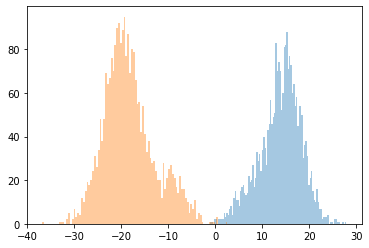

In [124]:
plt.hist(preds[Y_batch.detach().cpu().numpy() == 1], bins=100, alpha=0.4);
plt.hist(preds[Y_batch.detach().cpu().numpy() == 0], bins=100, alpha=0.4);

In [125]:
model.eval()
with torch.no_grad():
    print(model.log_prob(X_test_tensor[:10000], Y_test_tensor[:10000]).mean().item())

-1460.0169677734375


In [126]:
model.eval()
clf.eval()
with torch.no_grad():
    n_samples = 1000
    samples = model.sample_n(n_samples, Y_test_tensor[:n_samples])
    calib_constant = logsumexp(clf(samples.view(-1, 1, 28, 28)).detach().cpu().numpy()) - np.log(n_samples)
print(calib_constant)

/home/robdrynkin/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


-6.751377367414449


In [128]:
model.eval()
clf.eval()
with torch.no_grad():
    logits = clf(X_test_tensor[:10000].view(-1, 1, 28, 28))
    print(
        (model.log_prob(X_test_tensor[:10000], Y_test_tensor[:10000]) + logits).mean().item() - calib_constant
    )

-1439.3184468513355


In [24]:
samples

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
trained_clfs = []

for model in trained_models:
    model.eval()
    n_samples = X_train.shape[0]
    with torch.no_grad():
        samples = model.sample_n(n_samples).detach().cpu().numpy()
    X_clf = np.vstack([X_train, samples])
    Y_clf = np.hstack([np.ones(n_samples), np.zeros(n_samples)])

    X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X_clf, Y_clf, test_size=0.2)
    
    trained_clfs.append(
        CatBoostClassifier(
            100, eval_metric='AUC',
            metric_period=50,
            use_best_model=False
        ).fit(
            X_train_clf, Y_train_clf,
            eval_set=(X_test_clf, Y_test_clf)
        )
    )

In [ ]:
def compute_metrics(model, clf, n_samples=1000):
    ll = model.log_prob(X_train_tensor).mean().item()
    
    n_samples = X_train.shape[0]
    with torch.no_grad():
        samples = model.sample_n(n_samples).detach().cpu().numpy()
    X_clf = np.vstack([X_train, samples])
    Y_clf = np.hstack([np.ones(n_samples), np.zeros(n_samples)])
    X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X_clf, Y_clf, test_size=0.2)
    clf_roc_auc = roc_auc_score(Y_test_clf, expit(clf(X_test_clf)))
    
    samples = model.sample_n(n_samples).detach().cpu().numpy()
    logits = clf(samples)
    calib_constant = logsumexp(logits) - np.log(n_samples)

    qs = {
        'min':  np.min(logits),
        '0.01': np.quantile(logits, 0.01),
        '0.25': np.quantile(logits, 0.25),
        '0.50': np.quantile(logits, 0.50),
        '0.75': np.quantile(logits, 0.75),
        '0.99': np.quantile(logits, 0.99),
        'max':  np.max(logits),
    }
    
    calib_model = CalibratedModel(clf, model, logit=True, n_samples_c=n_samples)
    
    calib_ll = neg_log_likelihood(calib_model, X_test_tensor) - calib_constant
    n_samples_start = calib_model.model.samples_cnt
    calib_model.sample_n(n_samples)
    real_samples_frac = (calib_model.model.samples_cnt - n_samples_start) / n_samples
    
    return {
        'model': model,
        'clf': clf,
        'calib_model': calib_model,
        'll': ll,
        'clf_roc_auc': clf_roc_auc,
        'calib_constant': calib_constant,
        'logits': logits,
        'calib_ll': calib_ll,
        'real_samples_frac': real_samples_frac,
        'quantiles': qs
    }

In [ ]:
metrics = {
    f'{i}': compute_metrics(trained_models[i], wrap_cb(trained_clfs[i]), 10000)
    for i in range(len(trained_models))
}
metrics.update({
    f'{i}_clip_log_4': compute_metrics(trained_models[i], wrap_cb(trained_clfs[i], np.log(4)), 10000)
    for i in range(len(trained_models))
})

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(18, 5 * 4))

axs[0].plot([metrics[f'{i}']['ll'] for i in range(len(trained_models))], label='nf')
axs[0].plot([metrics[f'{i}']['calib_ll'] for i in range(len(trained_models))], label='calib nf')
axs[0].plot([metrics[f'{i}_clip_log_4']['calib_ll'] for i in range(len(trained_models))], label='calib nf cliped')
axs[0].set_title('Test log likelihood')
axs[0].legend()

axs[1].plot([metrics[f'{i}']['clf_roc_auc'] for i in range(len(trained_models))], label='classic')
axs[1].plot([metrics[f'{i}_clip_log_4']['clf_roc_auc'] for i in range(len(trained_models))], label='clip log 4')
axs[1].legend()
axs[1].set_title('Classifier AUC-ROC')

for stat in ['min', '0.01', '0.99', 'max']:
    axs[2].plot([metrics[f'{i}']['quantiles'][stat] for i in range(len(trained_models))], label=stat)
axs[2].legend()

for stat in ['max']:
    axs[2].plot([metrics[f'{i}_clip_log_4']['quantiles'][stat] for i in range(len(trained_models))], label=stat + ' clip log 4')
axs[2].legend()


axs[3].plot([metrics[f'{i}']['real_samples_frac'] for i in range(len(trained_models))], label='calibrated nf')
axs[3].plot([metrics[f'{i}_clip_log_4']['real_samples_frac'] for i in range(len(trained_models))], label='calibrated nf clip log 4')
# axs[3].plot(real_samples_frac['log 4'])
axs[3].set_title('Real samples frac')
axs[3].legend()

# axs[3].yaxis.set_ticks(np.arange(0, 26, 2))

for i in range(4):
    axs[i].grid()

In [ ]:
clf_roc_auc, calib_constant, logits, calib_ll, real_samples_frac = zip(*metrics)

In [ ]:
plt.plot(clf_roc_auc)

In [ ]:
cliped_clfs = [
    {
        'inf': wrap_cb(clf),
#         'log 2': wrap_cb(clf, np.log(2)),
        'log 4': wrap_cb(clf, np.log(4))
    } for clf in trained_clfs
]

In [ ]:
qs = {
    '1': [],
    '25': [],
    '50': [],
    '75': [],
    '99': []
}
for i, (model, clfs, ll, auc) in enumerate(zip(trained_models, cliped_clfs, metrics_ll_test, clfs_auc)):
    all_logits = {}
    for name, clf in clfs.items():
        samples = model.sample_n(1000).detach().cpu().numpy()
        logits = clf(samples)
        calib_constant = logsumexp(logits) - np.log(len(logits))
        logits -= calib_constant
        all_logits[name] = logits
        
    qs['1'].append({
        name: np.quantile(logits, 0.01)
        for name, logits in all_logits.items()
    })
    qs['25'].append({
        name: np.quantile(logits, 0.25)
        for name, logits in all_logits.items()
    })
    qs['50'].append({
        name: np.quantile(logits, 0.5)
        for name, logits in all_logits.items()
    })
    qs['75'].append({
        name: np.quantile(logits, 0.74)
        for name, logits in all_logits.items()
    })
    qs['99'].append({
        name: np.quantile(logits, 0.99)
        for name, logits in all_logits.items()
    })

In [ ]:
calib_lls = {name: [] for name in cliped_clfs[0].keys()}
real_samples_frac = {name: [] for name in cliped_clfs[0].keys()}

for i, (model, clfs, ll, auc) in enumerate(zip(trained_models, cliped_clfs, metrics_ll_test, clfs_auc)):
    for name, clf in clfs.items():
        calib_model = CalibratedModel(clf, model, logit=True, n_samples_c=1000)

        samples = model.sample_n(10000).detach().cpu().numpy()
        logits = clf(samples)
        calib_constant = logsumexp(logits) - np.log(len(logits))
        calib_lls[name].append(
            neg_log_likelihood(calib_model, X_test_tensor) - calib_constant
        )
        n_samples_start = calib_model.model.samples_cnt
        calib_model.sample_n(10000)
        real_samples_frac[name].append((calib_model.model.samples_cnt - n_samples_start) / 10000)

In [ ]:
fig, axs = plt.subplots(len(trained_models), 4, figsize=(18, 5 * len(trained_models)))

X_val = np.transpose(np.dstack(np.meshgrid(
    np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
    np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
)), axes=[1, 0, 2]).astype(np.float32)

for i, (model, clfs, ll, auc, c_ll) in enumerate(zip(trained_models, cliped_clfs, metrics_ll_test, clfs_auc, calib_lls['inf'])):
    
    clf = clfs['log 4']
    n_samples = X_train.shape[0]
    samples = model.sample_n(n_samples).detach().cpu().numpy()
    
    axs[i, 0].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
    
#     clf = wrap_cb(clf, np.log(2))
    logits = clf(samples)
#     logits = clf(samples)
    calib_constant = logsumexp(logits) - np.log(len(logits))
    axs[i, 3].hist(logits - calib_constant, bins=20)
    max_logit = np.max(logits) - calib_constant
    axs[i, 3].set_title(f'Calib constant = {round(calib_constant, 2)}, max = {round(max_logit, 2)}')
    
    logits = clf(X_val.reshape(-1, 2))
#     logits = clf(X_val.reshape(-1, 2))
    model.eval()
    with torch.no_grad():
        log_probs = model.log_prob(
            torch.from_numpy(
                X_val.reshape(-1, 2),
            ).to(device)
        ).detach().cpu().numpy()
        probs = np.exp(log_probs).reshape(X_val.shape[0], X_val.shape[1])
        probs_fixed = np.exp(log_probs + logits).reshape(X_val.shape[0], X_val.shape[1])

    axs[i, 1].imshow(probs.T[::-1])
    axs[i, 1].set_title(f'll = {round(ll, 2)}')
    
    axs[i, 2].imshow(probs_fixed.T[::-1])
#     print(c_ll, type(c_ll), auc, type(auc))
    axs[i, 2].set_title(f'll = {round(c_ll, 2)}, auc-roc={round(auc, 2)}')

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(18, 5 * 4))

axs[0].plot(metrics_ll_test, label='nf')
axs[0].plot(calib_lls['log 4'], label='calibrated nf')
axs[0].set_title('Test log likelihood')
axs[0].legend()
axs[1].plot(clfs_auc)
axs[1].set_title('Classifier AUC-ROC')
for k, v in qs.items():
    axs[2].plot([x['log 4'] for x in v], label=str(float(k) / 100))
    axs[2].legend()
axs[2].set_title('Logits quantiles')
axs[3].plot(real_samples_frac['log 4'])
axs[3].set_title('Real samples frac')

axs[3].yaxis.set_ticks(np.arange(0, 26, 2))

for i in range(4):
    axs[i].grid()

In [ ]:
calibrated_model = CalibratedModel(clfs[-1], trained_models[-1], logit=True, n_samples_c=1000)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(X_train[:10000, 0], X_train[:10000, 1], alpha=0.3)
axs[0].set_title('real data')

samples = calibrated_model.model.sample_n(10000).detach().cpu().numpy()
axs[1].scatter(samples[:, 0], samples[:, 1], alpha=0.3)
axs[1].set_title('nf samples')

samples = calibrated_model.sample_n(10000)
axs[2].scatter(samples[:, 0], samples[:, 1], alpha=0.3)
axs[2].set_title('calibrated nf samples')